In [27]:
import os
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from IPython.display import SVG
from tensorflow import keras
from keras.applications import InceptionV3
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

### Bộ dữ liệu

In [4]:
train_data_dir = "../data/train/"
img_width, img_height = 224, 224 
channels = 3
batch_size = 64
num_images= 50
image_arr_size= img_width * img_height * channels

In [3]:
def get_images(image_dir):

    image_index = 0
    image_arr_size= img_width * img_height * channels
    images = np.ndarray(shape=(num_images, image_arr_size))
    labels = np.array([])                       

    for type in os.listdir(image_dir)[:50]:
        type_images = os.listdir(image_dir + type)
        labels= np.append(labels, type.split('-')[1])
        
        for image in type_images[:1]:
            image_file = os.path.join(image_dir, type + '/', image)
            image_data = mpimg.imread(image_file)
            image_resized = resize(image_data, (img_width, img_height), anti_aliasing=True)
            images[image_index, :] = image_resized.flatten()
            print (type, ':', image)
            image_index += 1

    return (images, labels)

def plot_images(instances, images_per_row=10, **options):
    size = img_width
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(img_width, img_height, channels) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((img_width, img_height * n_empty)))
    for row in range(n_rows):
        if (row == len(instances)/images_per_row):
            break
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.figure(figsize=(20,20))
    plt.imshow(image, **options)
    plt.axis("off")
    plt.savefig('dogs_images.png', transparent= True, bbox_inches= 'tight', dpi= 900)
    plt.show()

n02085620-Chihuahua : n02085620_10074.jpg
n02085782-Japanese_spaniel : n02085782_1039.jpg
n02085936-Maltese_dog : n02085936_10073.jpg
n02086079-Pekinese : n02086079_10159.jpg
n02086240-Shih-Tzu : n02086240_1011.jpg
n02086646-Blenheim_spaniel : n02086646_1014.jpg
n02086910-papillon : n02086910_10204.jpg
n02087046-toy_terrier : n02087046_1004.jpg
n02087394-Rhodesian_ridgeback : n02087394_10014.jpg
n02088094-Afghan_hound : n02088094_1003.jpg
n02088238-basset : n02088238_10013.jpg
n02088364-beagle : n02088364_10108.jpg
n02088466-bloodhound : n02088466_10083.jpg
n02088632-bluetick : n02088632_101.jpg
n02089078-black-and-tan_coonhound : n02089078_1021.jpg
n02089867-Walker_hound : n02089867_1029.jpg
n02089973-English_foxhound : n02089973_1.jpg
n02090379-redbone : n02090379_1020.jpg
n02090622-borzoi : n02090622_10281.jpg
n02090721-Irish_wolfhound : n02090721_1002.jpg
n02091032-Italian_greyhound : n02091032_10079.jpg
n02091134-whippet : n02091134_10107.jpg
n02091244-Ibizan_hound : n02091244_100

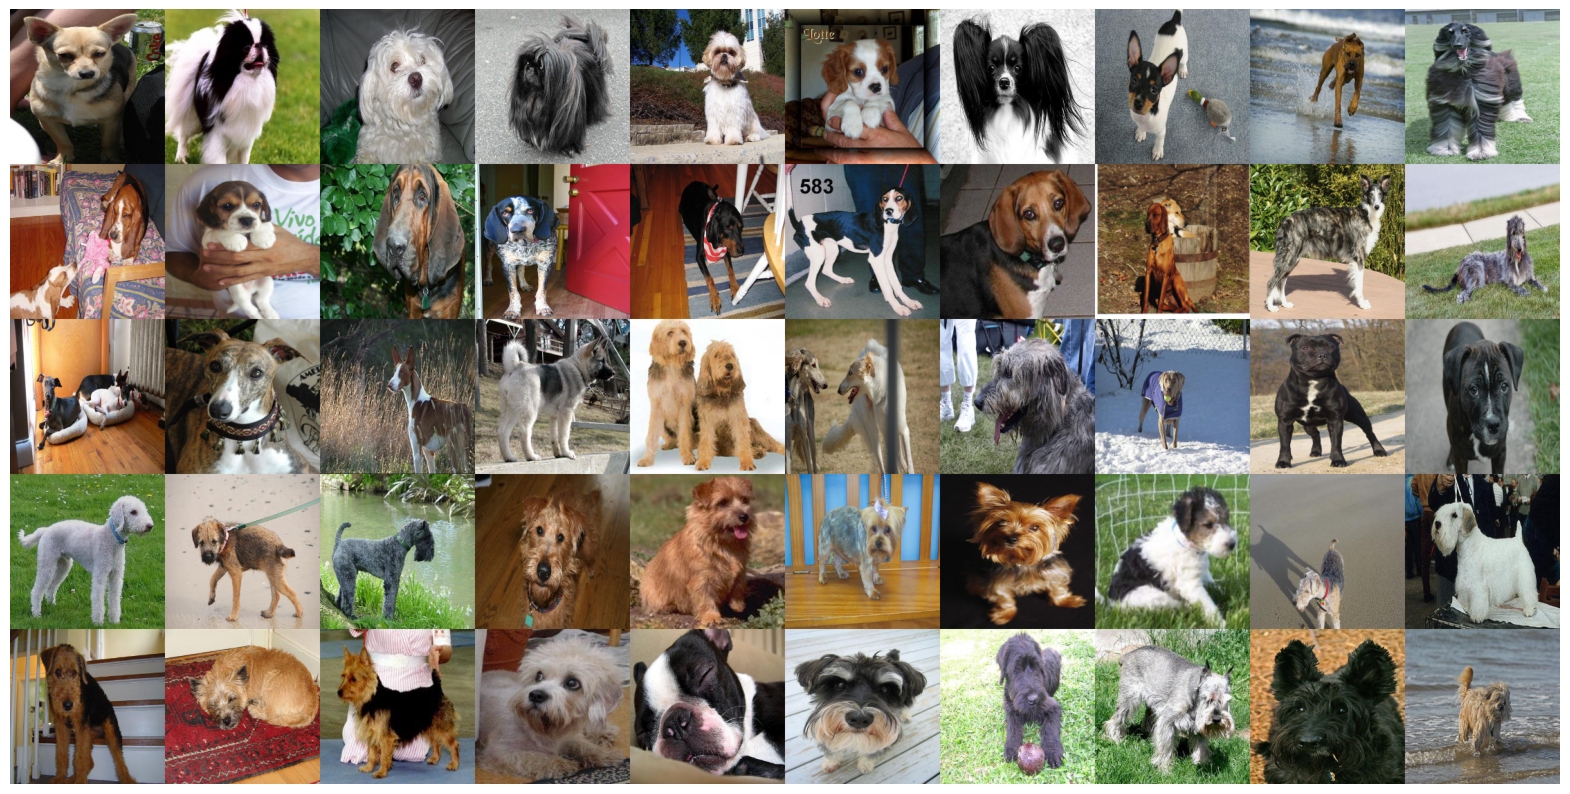

In [4]:
images, labels = get_images(train_data_dir)
plot_images(images)

### Tiền xử lý dữ liệu

In [5]:
# Tăng cường dữ liệu
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Chuẩn hóa giá trị pixel từ [0, 255] về [0, 1] để cải thiện hiệu quả huấn luyện.
    shear_range=0.2,              # Áp dụng phép biến đổi cắt xén (shearing) với góc tối đa là 20%. Tạo hiệu ứng nghiêng ảnh theo một hướng.
    zoom_range=0.2,               # Phóng to hoặc thu nhỏ ngẫu nhiên trong khoảng ±20% kích thước gốc.
    horizontal_flip=True,         # Lật ảnh theo chiều ngang ngẫu nhiên, giúp mô hình trở nên bất biến với hướng đối tượng.
    rotation_range=20,            # Xoay ngẫu nhiên ảnh trong khoảng ±20 độ, giúp tăng tính đa dạng của dữ liệu.
    width_shift_range=0.2,        # Dịch chuyển ngang ngẫu nhiên tối đa 20% kích thước ảnh gốc.
    height_shift_range=0.2,       # Dịch chuyển dọc ngẫu nhiên tối đa 20% kích thước ảnh gốc.
    validation_split=0.2,         # Tách 20% dữ liệu để làm tập validation (phân chia giữa train và validation).

valid_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)

In [6]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1337
)

Found 14860 images belonging to 120 classes.
Found 3662 images belonging to 120 classes.


In [7]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)

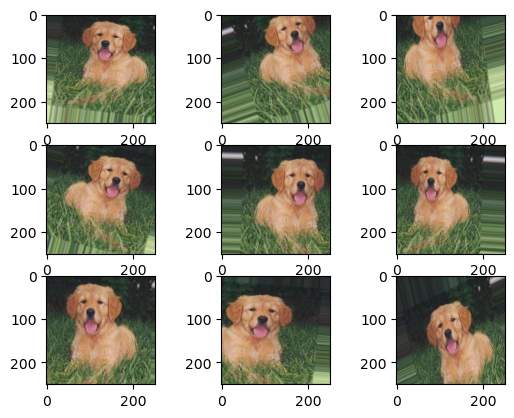

In [8]:
img = load_img('../data/train/n02099601-golden_retriever/n02099601_5.jpg')
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.__next__()
    image = batch[0]
    plt.imshow(image)

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

### Cấu hình model

In [70]:
base_model = InceptionV3(input_shape=(img_height, img_width, channels), weights='imagenet', include_top=False)

In [71]:
for layer in base_model.layers:
    layer.trainable= False
# Tạo lớp Input riêng để không hiển thị kiến trúc InceptionV3
inputs = Input(shape=(img_height, img_width, channels))

# Chạy qua base_model nhưng không hiển thị chi tiết của nó
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(120, activation='softmax')(x)

In [72]:
model = Model(inputs = inputs, outputs = x)

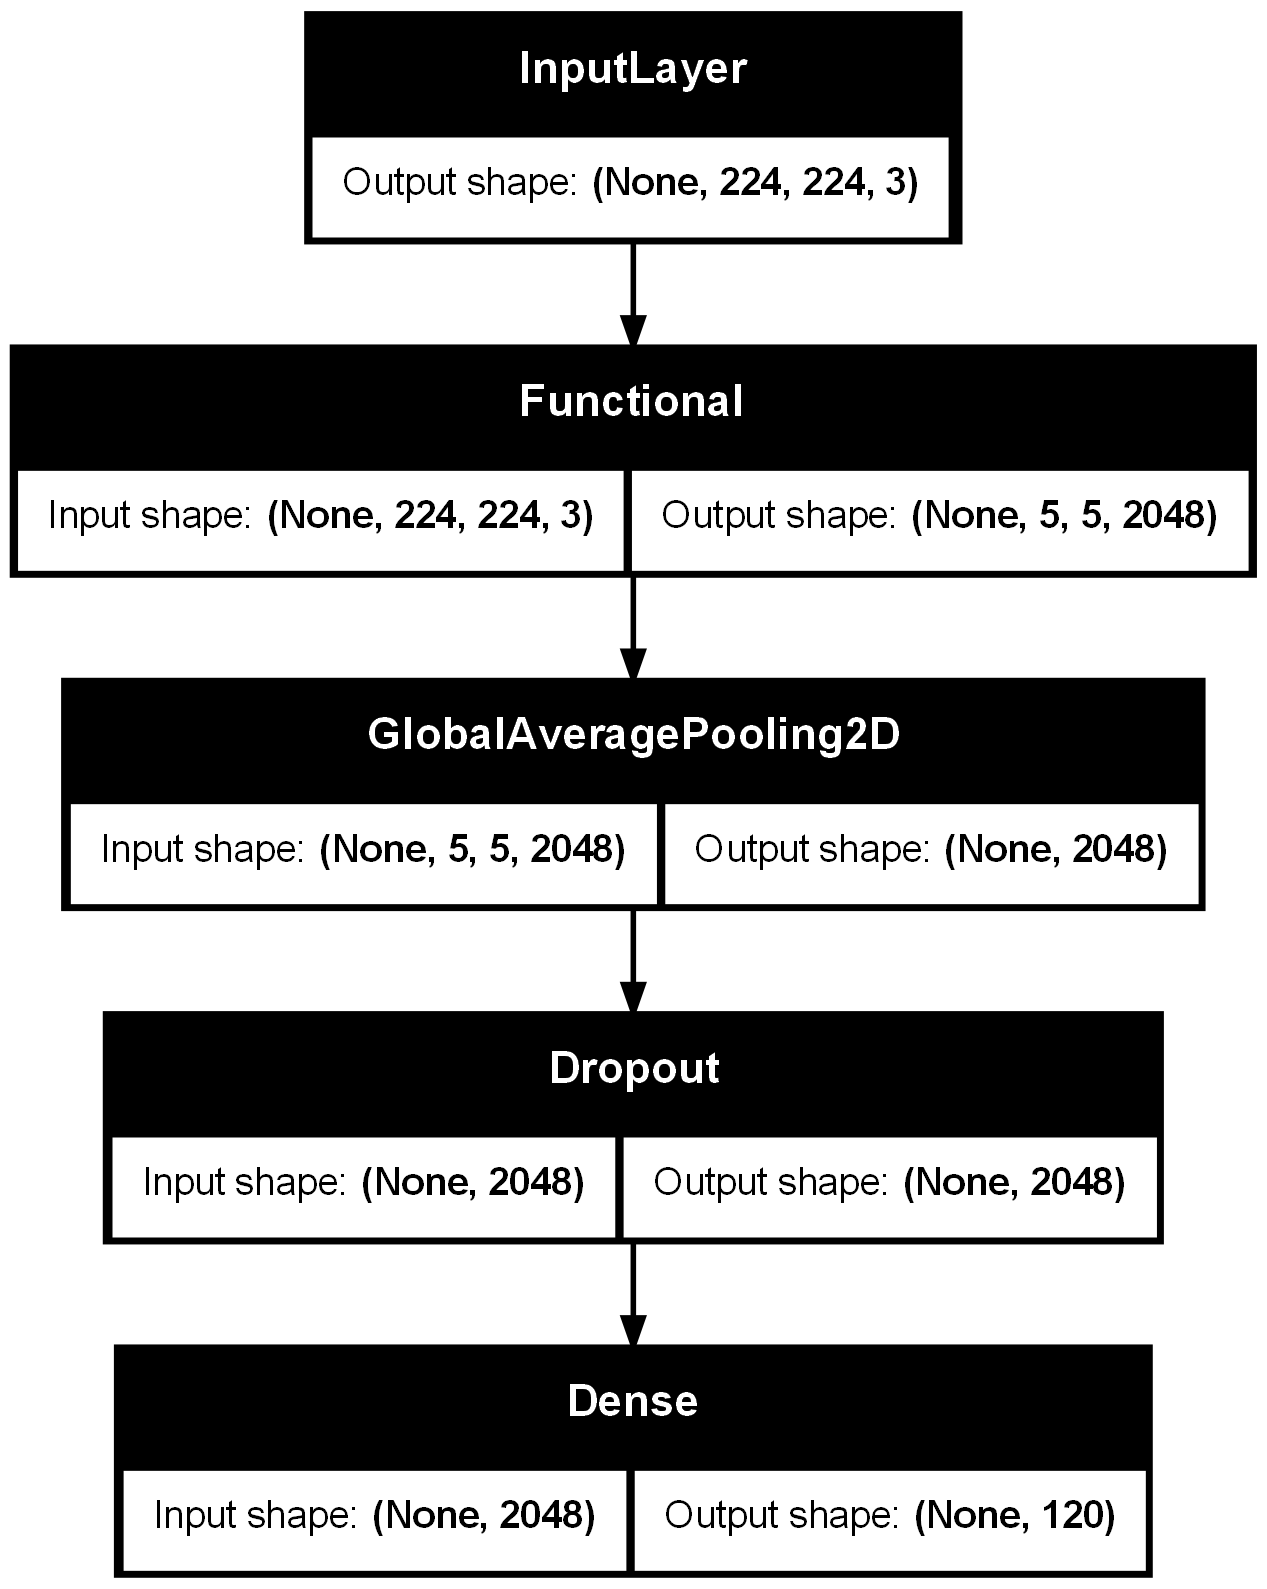

In [73]:
plot_model(model, to_file='model_plot.png', show_shapes=True, expand_nested=False)

In [13]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
checkpoint = ModelCheckpoint(
    'baseline_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

callbacks = [checkpoint, earlystop]

In [15]:
history = model.fit(
    train_generator, 
    epochs = 30,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/30


D:\Desktop\hocmay\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.92271, saving model to baseline_model.keras
232/232 - 403s - 2s/step - accuracy: 0.2605 - loss: 3.5666 - val_accuracy: 0.6541 - val_loss: 1.9227
Epoch 2/30


D:\Desktop\hocmay\env\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: val_loss did not improve from 1.92271
232/232 - 1s - 6ms/step - accuracy: 0.5469 - loss: 2.1445 - val_accuracy: 0.6429 - val_loss: 2.0371
Epoch 3/30

Epoch 3: val_loss improved from 1.92271 to 1.05661, saving model to baseline_model.keras
232/232 - 366s - 2s/step - accuracy: 0.6136 - loss: 1.7110 - val_accuracy: 0.7569 - val_loss: 1.0566
Epoch 4/30

Epoch 4: val_loss did not improve from 1.05661
232/232 - 1s - 6ms/step - accuracy: 0.6094 - loss: 1.4838 - val_accuracy: 0.7857 - val_loss: 1.1706
Epoch 5/30

Epoch 5: val_loss improved from 1.05661 to 0.84913, saving model to baseline_model.keras
232/232 - 366s - 2s/step - accuracy: 0.6864 - loss: 1.2380 - val_accuracy: 0.7766 - val_loss: 0.8491
Epoch 6/30

Epoch 6: val_loss improved from 0.84913 to 0.70071, saving model to baseline_model.keras
232/232 - 2s - 8ms/step - accuracy: 0.7500 - loss: 0.9691 - val_accuracy: 0.8571 - val_loss: 0.7007
Epoch 7/30

Epoch 7: val_loss did not improve from 0.70071
232/232 - 366s - 2s/step - ac

### Đánh giá model

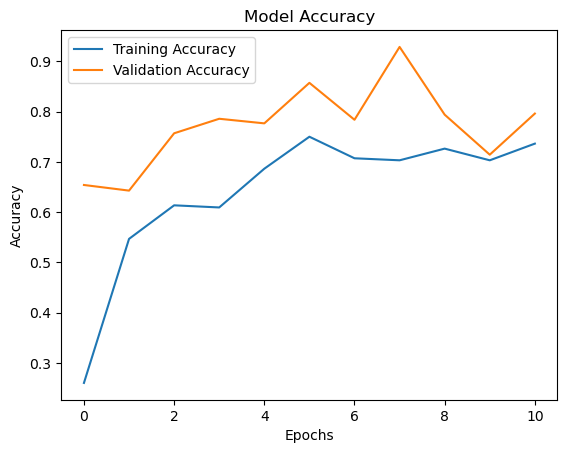

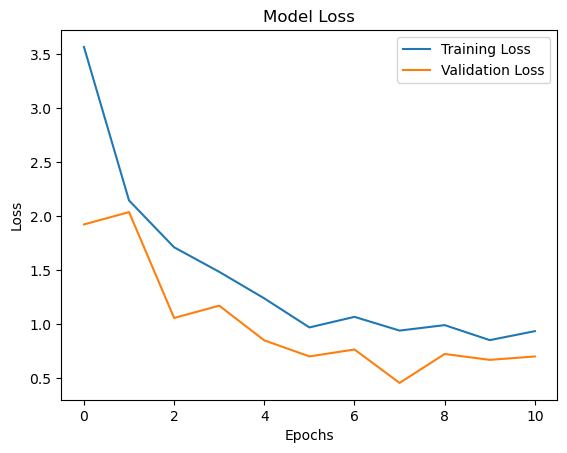

In [16]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

In [75]:
model.save("baseline_model.keras")